<a href="https://colab.research.google.com/github/ApolloniosN/3594/blob/main/Federated_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#εισαγωγή βιβλιοθηκών - πακέτων
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.exceptions import UndefinedMetricWarning
import warnings

In [2]:
#δημιουργία εικονικών εργαζόμενων που αντιπροσωπεύουν απομακρυσμένες συσκευές
device_partners = [torch.device("cuda" if torch.cuda.is_available() else "cpu") for _ in range(5)]

In [3]:
#δημιουργία συνθετικών δεδομένων για κάθε συσκευή
data_devices = [torch.randn(100, 10, device=device) for device in device_partners]
target_devices = [torch.randint(0, 2, (100,), device=device) for device in device_partners]

In [4]:
#δημιουργία νευρωνικού δικτύου
class SophisticatedModel(torch.nn.Module):
    def __init__(self):
        super(SophisticatedModel, self).__init__()
        self.fc1 = torch.nn.Linear(10, 64)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(64, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)

In [5]:
#αρχικοποιήση του γενικού (global) μοντέλου ως τον μέσο όρο των αρχικών τοπικών (local) μοντέλων
global_model = SophisticatedModel().to(device_partners[0])
global_optimizer = torch.optim.Adam(global_model.parameters(), lr=0.001)

for param_global, param_local in zip(global_model.parameters(), SophisticatedModel().parameters()):
    param_global.data.copy_(param_local.data)

In [6]:
#lίστες για την αποθήκευση των μέσων μετρήσεων για κάθε ομοσπονδιακό συνεργάτη
avg_precision_list = []
avg_recall_list = []
avg_f1_list = []
avg_accuracy_list = []

In [7]:
#προσομοίωση της διαδικασίας ομοσπονδιακής μάθησης
num_rounds = 10
batch_size = 32

In [8]:
#αρχικοποιήση προηγούμενων μετρήσεων με ψευδείς τιμές για την διασφαλίση ότι ο πρώτος γύρος ενημερώνει πάντα το καθολικό μοντέλο
prev_avg_precision = float('inf')
prev_avg_recall = float('inf')
prev_avg_f1 = float('inf')
prev_avg_accuracy = -1

In [9]:
#ορισμός τοπικών μοντέλων και βελτιστοποιητών
models = [SophisticatedModel().to(device) for device in device_partners]
optimizers = [torch.optim.Adam(model.parameters(), lr=0.001) for model in models]

for round in range(1, num_rounds + 1):
    print(f"Round {round}/{num_rounds}")

    #εκπαίδευση του κάθε τοπικού μοντέλου με ροές δεδομένων (batches)
    for model, data, target, optimizer in zip(models, data_devices, target_devices, optimizers):
        model.train()
        for i in range(0, len(data), batch_size):
            optimizer.zero_grad()
            data_batch, target_batch = data[i:i+batch_size], target[i:i+batch_size]
            output_device = model(data_batch)
            loss_device = torch.nn.BCELoss()(output_device.view(-1), target_batch.float())
            loss_device.backward()
            optimizer.step()

    #αξιολόγηση μοντέλου για κάθε συσκευή
    precision_list = []
    recall_list = []
    f1_list = []
    accuracy_list = []

    for idx, (model, data, target) in enumerate(zip(models, data_devices, target_devices)):
        model.eval()
        with torch.no_grad():
            y_true_device = target.cpu().numpy()
            y_pred_device = (model(data).view(-1).cpu().numpy() > 0.5).astype(int)

            try:
                precision_device, recall_device, f1_device, _ = precision_recall_fscore_support(y_true_device, y_pred_device, average='binary')
            except UndefinedMetricWarning as e:
                precision_device, recall_device, f1_device = 0.0, 0.0, 0.0

            accuracy_device = accuracy_score(y_true_device, y_pred_device)

            precision_list.append(precision_device)
            recall_list.append(recall_device)
            f1_list.append(f1_device)
            accuracy_list.append(accuracy_device)

        model.train()

    #πολογισμός του μέσου όρου κάθε μετρικού για κάθε ομοσπονδιακό συνεργάτη
    avg_precision = sum(precision_list) / len(precision_list)
    avg_recall = sum(recall_list) / len(recall_list)
    avg_f1 = sum(f1_list) / len(f1_list)
    avg_accuracy = sum(accuracy_list) / len(accuracy_list)

    #έλεγχος για το εάν η ακρίβεια έχει βελτιωθεί από τον προηγούμενο γύρο, εάν ναι, ενημέρωση του καθολικού μοντέλου
    if avg_accuracy >= prev_avg_accuracy:
        print(f"Global model updated in round {round}:")
        print(f" - Average Accuracy: {avg_accuracy} (Previous: {prev_avg_accuracy})")
        for param_global, param_local in zip(global_model.parameters(), models[0].parameters()):
            param_global.data.copy_(param_local.data)

    avg_precision_list.append(avg_precision)
    avg_recall_list.append(avg_recall)
    avg_f1_list.append(avg_f1)
    avg_accuracy_list.append(avg_accuracy)

    #αποθήκευση των τρέχοντων μοντέλων ως προηγούμενα μοντέλα για τον επόμενο γύρο
    prev_models = [model.state_dict() for model in models]
    prev_avg_precision = avg_precision
    prev_avg_recall = avg_recall
    prev_avg_f1 = avg_f1
    prev_avg_accuracy = avg_accuracy

Round 1/10
Global model updated in round 1:
 - Average Accuracy: 0.524 (Previous: -1)
Round 2/10
Global model updated in round 2:
 - Average Accuracy: 0.53 (Previous: 0.524)
Round 3/10
Global model updated in round 3:
 - Average Accuracy: 0.542 (Previous: 0.53)
Round 4/10
Global model updated in round 4:
 - Average Accuracy: 0.5680000000000001 (Previous: 0.542)
Round 5/10
Global model updated in round 5:
 - Average Accuracy: 0.5720000000000001 (Previous: 0.5680000000000001)
Round 6/10
Global model updated in round 6:
 - Average Accuracy: 0.5820000000000001 (Previous: 0.5720000000000001)
Round 7/10
Global model updated in round 7:
 - Average Accuracy: 0.592 (Previous: 0.5820000000000001)
Round 8/10
Global model updated in round 8:
 - Average Accuracy: 0.6060000000000001 (Previous: 0.592)
Round 9/10
Global model updated in round 9:
 - Average Accuracy: 0.6220000000000001 (Previous: 0.6060000000000001)
Round 10/10
Global model updated in round 10:
 - Average Accuracy: 0.634 (Previous: 0.6

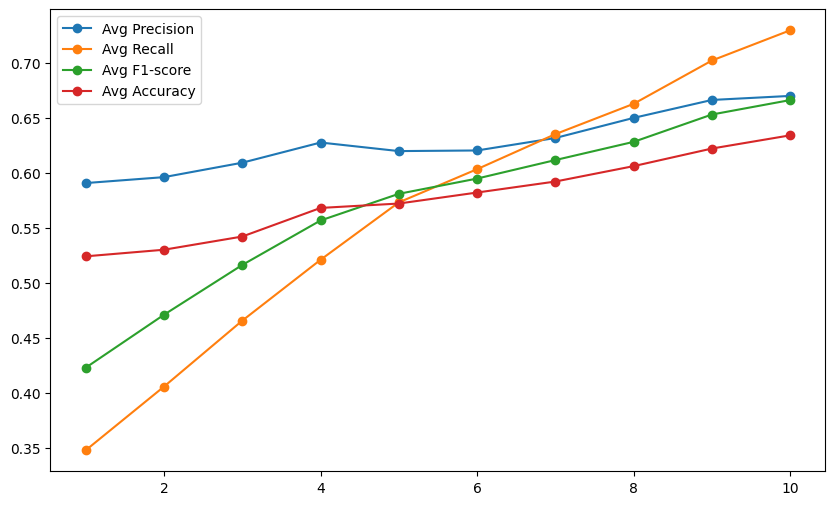

In [10]:
#οπτικοποίηση των μέσων τιμών μετρικών σε κάθε γύρο
rounds = list(range(1, num_rounds + 1))

plt.figure(figsize=(10, 6))
plt.plot(rounds, avg_precision_list, label='Avg Precision', marker='o')
plt.plot(rounds, avg_recall_list, label='Avg Recall', marker='o')
plt.plot(rounds, avg_f1_list, label='Avg F1-score', marker='o')
plt.plot(rounds, avg_accuracy_list, label='Avg Accuracy', marker='o')
plt.legend()
plt.show()